In [1]:
import torch
from torch import nn
from experiments.models import get_model
from experiments.data import get_data
from experiments.train import test, train
import blockers
import torch_subspace
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda")
train_data, test_data, num_classes = get_data(
    "cifar10", batch_size=512, data_path="./data"
)

In [3]:
loss_fn = nn.CrossEntropyLoss()

In [4]:
def interpolate_plot(pruner, blocker_name, sparsity):
    # Load the pruned model
    model = get_model("vgg16", num_classes=num_classes, device=device)
    torch_subspace.convert_model_to_lr(model)
    # Make sure the pruned model has the same blocking style
    if blocker_name == "square":
        blockers.square.make_blocks(model)
    elif blocker_name == "alds":
        blockers.alds.make_blocks(model, k=4)  # TODO: tune `k` value
    elif blocker_name == "none":
        pass
    else:
        raise ValueError(f"Invalid blocker: {blocker_name}")
    for module in model.modules():
        if not isinstance(module, torch_subspace.SubspaceLR):
            continue
        if not module.is_leaf:
            continue
        module.set_mask(torch.ones(module.max_rank()))
    model.load_state_dict(torch.load(f"./checkpoint/pruned_model_{pruner}_{blocker_name}_{int(sparsity * 1000)}.pt"))
    model = model.to(device)
    # Collect subspace modules together
    parent_modules: set[torch_subspace.SubspaceLR] = set()
    print(f"Pruned model num modules before collect: {len(list(model.modules()))}")
    test(model, test_data, loss_fn=loss_fn, device=device)
    for module in model.modules():
        if not isinstance(module, torch_subspace.SubspaceLR):
            continue
        parent = module
        while parent.parent_module is not None:
            parent = parent.parent_module[0]
        parent_modules.add(parent)
    for parent_module in parent_modules:
        parent_module.collect()
    print(f"Pruned model num modules: {len(list(model.modules()))}")
    test(model, test_data, loss_fn=loss_fn, device=device)
    # Load original (unpruned model)
    orig_model = get_model("vgg16", num_classes=num_classes, device=device)
    orig_model.load_state_dict(torch.load("./checkpoint/vgg16_cifar10_epoch_160"))
    torch_subspace.convert_model_to_lr(orig_model)
    print(f"Unpruned model num modules: {len(list(orig_model.modules()))}")
    test(orig_model, test_data, loss_fn=loss_fn, device=device)
    # Load interpolation model
    inter_model = get_model("vgg16", num_classes=num_classes, device=device)
    torch_subspace.convert_model_to_lr(inter_model)
    inter_model = inter_model.to(device)
    print(f"Interpolation model num modules: {len(list(inter_model.modules()))}")
    test(inter_model, test_data, loss_fn=loss_fn, device=device)
    # Perform interpolation
    losses = []
    accuracies = []
    t_vals = np.linspace(0, 1, num=21)
    with torch.no_grad():
        for i, t in enumerate(t_vals):
            for p_param, o_param, i_param in zip(model.parameters(), orig_model.parameters(), inter_model.parameters()):
                i_param.copy_(p_param * t + o_param * (1 - t))
            for p_buffer, o_buffer, i_buffer in zip(model.buffers(), orig_model.buffers(), inter_model.buffers()):
                i_buffer.copy_(p_buffer * t + o_buffer * (1 - t))
            val_loss, val_acc = test(inter_model, test_data, loss_fn=loss_fn, device=device, verbose=False)
            print(f"Evaluated {i=} {t=} {val_loss=:.3f} {val_acc*100=:.1f}%", end="    \r")
            losses.append(val_loss)
            accuracies.append(val_acc)
    print()

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(t_vals, losses, label="Loss", color="red")
    ax2.plot(t_vals, accuracies, label="Accuracy", color="blue")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
    fig.legend(loc="lower left")
    plt.title(f"pruner: {pruner} blocker: {blocker_name} sparsitsy: {sparsity}")
    plt.show()

Pruned model num modules before collect: 354
[Test] Loss: 0.31832 | Accuracy: 0.9275
Pruned model num modules: 62
[Test] Loss: 0.31832 | Accuracy: 0.9275
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30247 | Accuracy: 0.1000
Evaluated i=20 t=1.0 val_loss=0.318 val_acc*100=92.8%    c*100=91.3%    


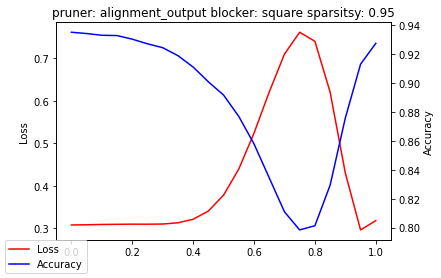

Pruned model num modules before collect: 354
[Test] Loss: 2.30258 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30258 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30273 | Accuracy: 0.1235
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


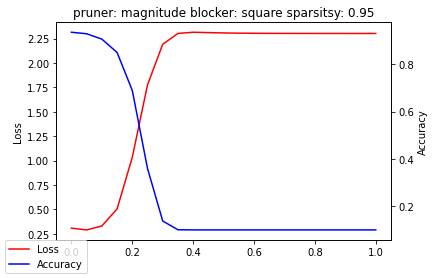

Pruned model num modules before collect: 354
[Test] Loss: 0.29758 | Accuracy: 0.9289
Pruned model num modules: 62
[Test] Loss: 0.29758 | Accuracy: 0.9289
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30294 | Accuracy: 0.1001
Evaluated i=20 t=1.0 val_loss=0.298 val_acc*100=92.9%    c*100=91.3%    


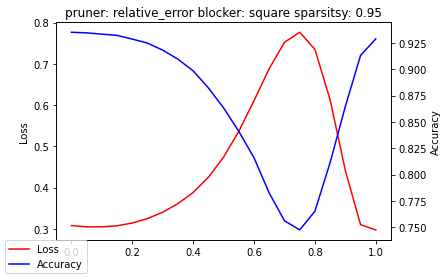

Pruned model num modules before collect: 354
[Test] Loss: 0.31322 | Accuracy: 0.9301
Pruned model num modules: 62
[Test] Loss: 0.31322 | Accuracy: 0.9301
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30338 | Accuracy: 0.1075
Evaluated i=20 t=1.0 val_loss=0.313 val_acc*100=93.0%    c*100=90.8%    


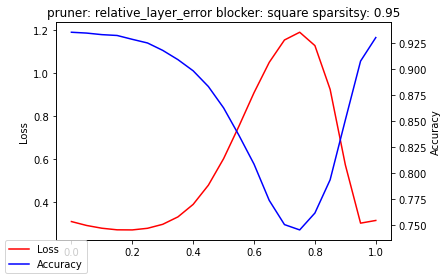

Pruned model num modules before collect: 172
[Test] Loss: 0.34848 | Accuracy: 0.9221
Pruned model num modules: 62
[Test] Loss: 0.34848 | Accuracy: 0.9221
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30189 | Accuracy: 0.1000
Evaluated i=20 t=1.0 val_loss=0.348 val_acc*100=92.2%    c*100=92.1%    


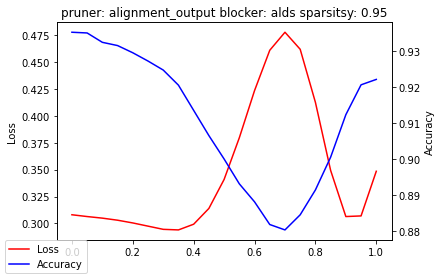

Pruned model num modules before collect: 172
[Test] Loss: 2.30259 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30235 | Accuracy: 0.1128
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


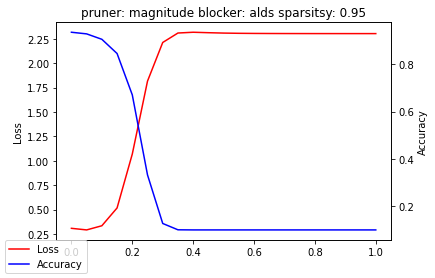

Pruned model num modules before collect: 172
[Test] Loss: 0.32775 | Accuracy: 0.9274
Pruned model num modules: 62
[Test] Loss: 0.32775 | Accuracy: 0.9274
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30234 | Accuracy: 0.1003
Evaluated i=20 t=1.0 val_loss=0.328 val_acc*100=92.7%    c*100=92.3%    


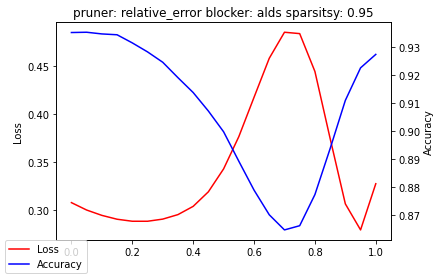

Pruned model num modules before collect: 172
[Test] Loss: 0.32941 | Accuracy: 0.9281
Pruned model num modules: 62
[Test] Loss: 0.32941 | Accuracy: 0.9281
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30257 | Accuracy: 0.1000
Evaluated i=20 t=1.0 val_loss=0.329 val_acc*100=92.8%    c*100=92.2%    


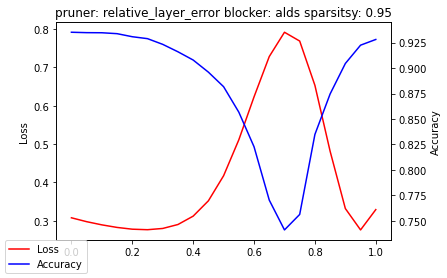

Pruned model num modules before collect: 62
[Test] Loss: 0.43447 | Accuracy: 0.8802
Pruned model num modules: 62
[Test] Loss: 0.43447 | Accuracy: 0.8802
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30287 | Accuracy: 0.0955
Evaluated i=20 t=1.0 val_loss=0.434 val_acc*100=88.0%    c*100=84.8%    


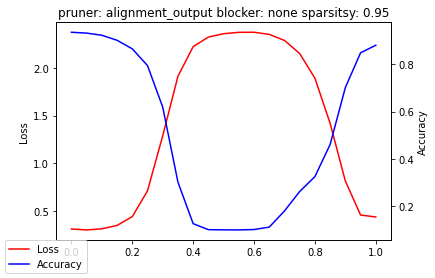

Pruned model num modules before collect: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30335 | Accuracy: 0.1014
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


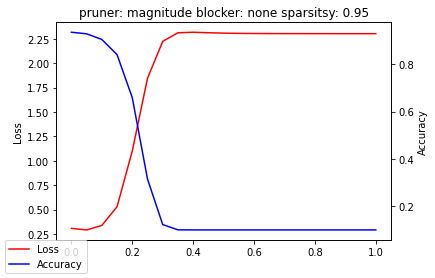

Pruned model num modules before collect: 62
[Test] Loss: 0.43153 | Accuracy: 0.8931
Pruned model num modules: 62
[Test] Loss: 0.43153 | Accuracy: 0.8931
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30288 | Accuracy: 0.1178
Evaluated i=20 t=1.0 val_loss=0.432 val_acc*100=89.3%    c*100=89.0%    


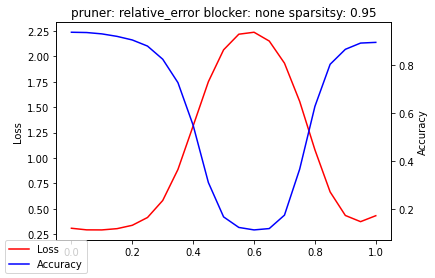

Pruned model num modules before collect: 62
[Test] Loss: 0.41126 | Accuracy: 0.8926
Pruned model num modules: 62
[Test] Loss: 0.41126 | Accuracy: 0.8926
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30299 | Accuracy: 0.0983
Evaluated i=20 t=1.0 val_loss=0.411 val_acc*100=89.3%    c*100=88.8%    


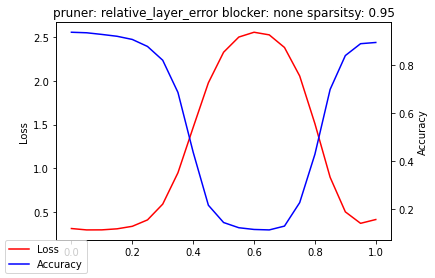

Pruned model num modules before collect: 354
[Test] Loss: 0.39761 | Accuracy: 0.9129
Pruned model num modules: 62
[Test] Loss: 0.39761 | Accuracy: 0.9129
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30274 | Accuracy: 0.1159
Evaluated i=20 t=1.0 val_loss=0.398 val_acc*100=91.3%    c*100=89.8%    


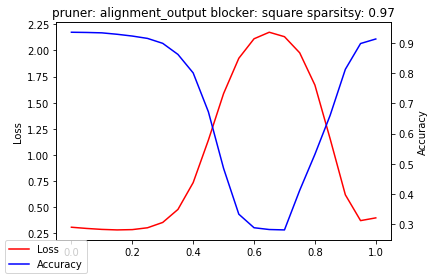

Pruned model num modules before collect: 354
[Test] Loss: 2.30258 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30258 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30281 | Accuracy: 0.0998
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


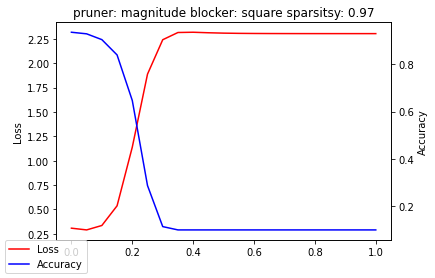

Pruned model num modules before collect: 354
[Test] Loss: 0.34578 | Accuracy: 0.9232
Pruned model num modules: 62
[Test] Loss: 0.34578 | Accuracy: 0.9232
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30243 | Accuracy: 0.1009
Evaluated i=20 t=1.0 val_loss=0.346 val_acc*100=92.3%    c*100=91.1%    


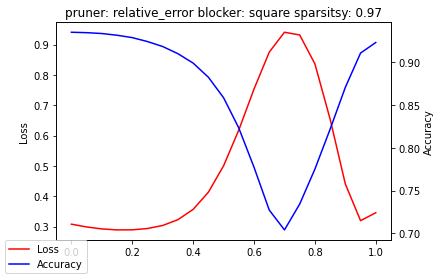

Pruned model num modules before collect: 354
[Test] Loss: 0.35989 | Accuracy: 0.9268
Pruned model num modules: 62
[Test] Loss: 0.35989 | Accuracy: 0.9268
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30288 | Accuracy: 0.1021
Evaluated i=20 t=1.0 val_loss=0.360 val_acc*100=92.7%    c*100=92.0%    


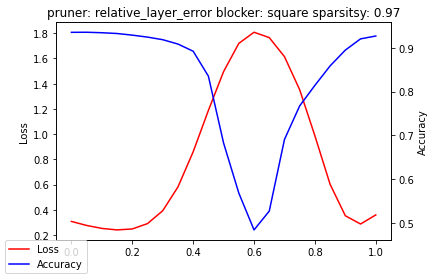

Pruned model num modules before collect: 172
[Test] Loss: 0.41893 | Accuracy: 0.9071
Pruned model num modules: 62
[Test] Loss: 0.41893 | Accuracy: 0.9071
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30304 | Accuracy: 0.1000
Evaluated i=20 t=1.0 val_loss=0.419 val_acc*100=90.7%    c*100=88.9%    


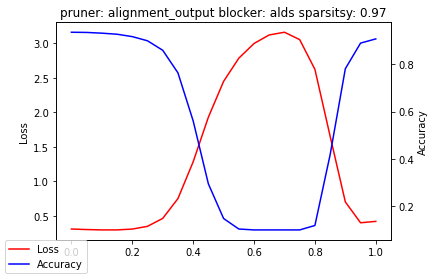

Pruned model num modules before collect: 172
[Test] Loss: 2.30258 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30258 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30324 | Accuracy: 0.1000
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


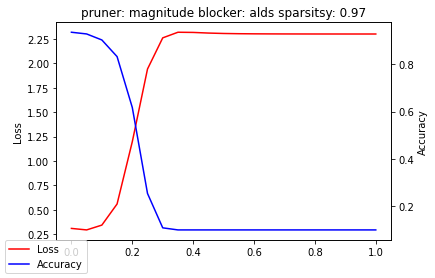

Pruned model num modules before collect: 172
[Test] Loss: 0.39312 | Accuracy: 0.9108
Pruned model num modules: 62
[Test] Loss: 0.39312 | Accuracy: 0.9108
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30220 | Accuracy: 0.0999
Evaluated i=20 t=1.0 val_loss=0.393 val_acc*100=91.1%    c*100=89.4%    


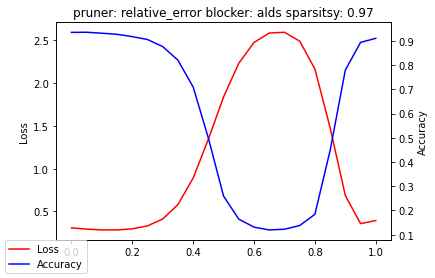

Pruned model num modules before collect: 172
[Test] Loss: 0.44203 | Accuracy: 0.9017
Pruned model num modules: 62
[Test] Loss: 0.44203 | Accuracy: 0.9017
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30265 | Accuracy: 0.1193
Evaluated i=20 t=1.0 val_loss=0.442 val_acc*100=90.2%    c*100=86.6%    


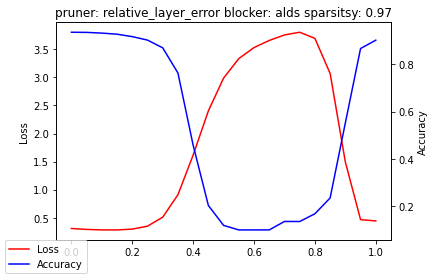

Pruned model num modules before collect: 62
[Test] Loss: 0.55701 | Accuracy: 0.8178
Pruned model num modules: 62
[Test] Loss: 0.55701 | Accuracy: 0.8178
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30294 | Accuracy: 0.0987
Evaluated i=20 t=1.0 val_loss=0.557 val_acc*100=81.8%    c*100=61.8%    


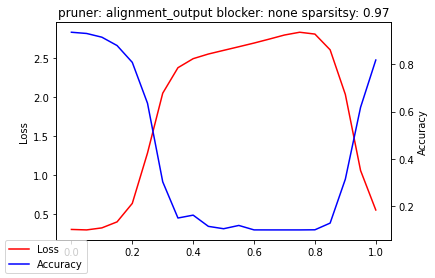

Pruned model num modules before collect: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30274 | Accuracy: 0.0999
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


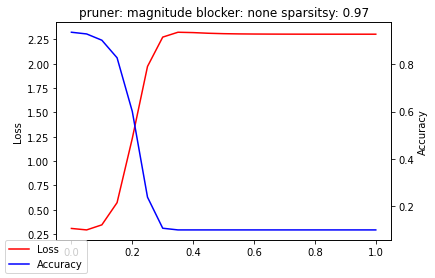

Pruned model num modules before collect: 62
[Test] Loss: 0.56787 | Accuracy: 0.8137
Pruned model num modules: 62
[Test] Loss: 0.56787 | Accuracy: 0.8137
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30335 | Accuracy: 0.1000
Evaluated i=20 t=1.0 val_loss=0.568 val_acc*100=81.4%    c*100=32.4%    


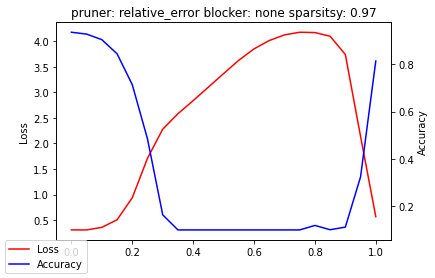

Pruned model num modules before collect: 62
[Test] Loss: 0.55913 | Accuracy: 0.8127
Pruned model num modules: 62
[Test] Loss: 0.55913 | Accuracy: 0.8127
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30296 | Accuracy: 0.1000
Evaluated i=20 t=1.0 val_loss=0.559 val_acc*100=81.3%    c*100=29.1%    


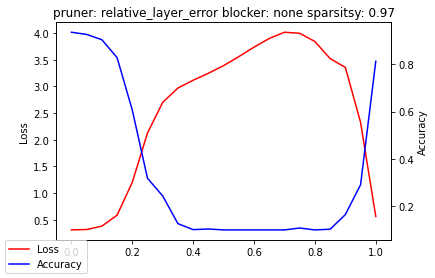

Pruned model num modules before collect: 354
[Test] Loss: 0.41347 | Accuracy: 0.8838
Pruned model num modules: 62
[Test] Loss: 0.41347 | Accuracy: 0.8838
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30280 | Accuracy: 0.1030
Evaluated i=20 t=1.0 val_loss=0.413 val_acc*100=88.4%    c*100=73.5%    


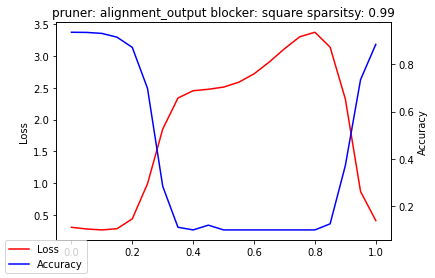

Pruned model num modules before collect: 354
[Test] Loss: 2.30259 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30294 | Accuracy: 0.0957
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


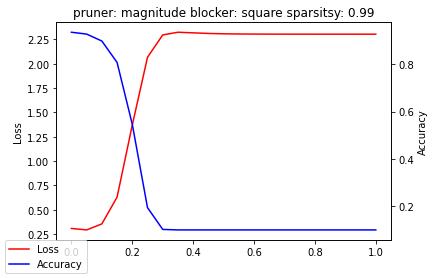

Pruned model num modules before collect: 354
[Test] Loss: 0.43390 | Accuracy: 0.8708
Pruned model num modules: 62
[Test] Loss: 0.43390 | Accuracy: 0.8708
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30287 | Accuracy: 0.1231
Evaluated i=20 t=1.0 val_loss=0.434 val_acc*100=87.1%    c*100=64.2%    


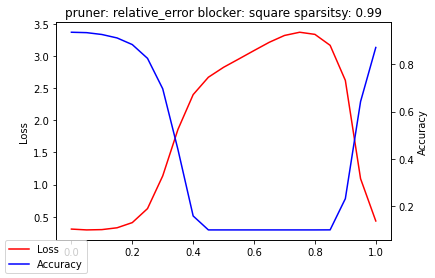

Pruned model num modules before collect: 354
[Test] Loss: 2.30259 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30253 | Accuracy: 0.0995
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


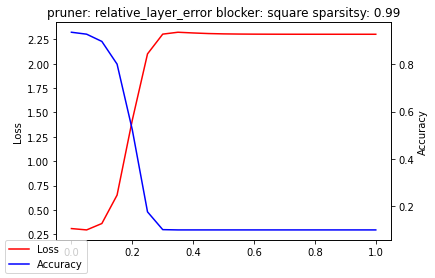

Pruned model num modules before collect: 172
[Test] Loss: 2.30259 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30299 | Accuracy: 0.1000
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


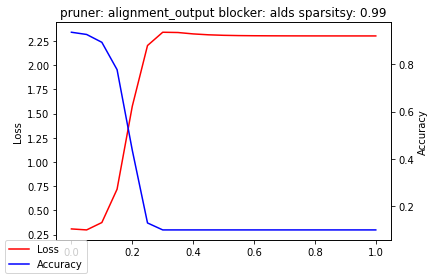

Pruned model num modules before collect: 172
[Test] Loss: 2.30259 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30216 | Accuracy: 0.0853
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


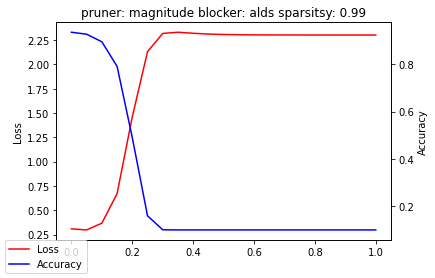

Pruned model num modules before collect: 172
[Test] Loss: 2.30259 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30261 | Accuracy: 0.0903
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


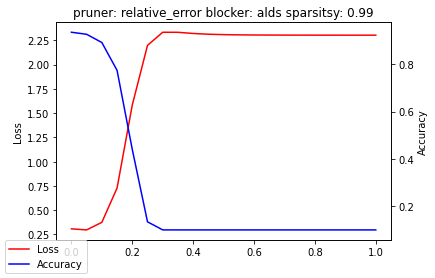

Pruned model num modules before collect: 172
[Test] Loss: 0.51100 | Accuracy: 0.8331
Pruned model num modules: 62
[Test] Loss: 0.51100 | Accuracy: 0.8331
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30298 | Accuracy: 0.0982
Evaluated i=20 t=1.0 val_loss=0.511 val_acc*100=83.3%    c*100=69.5%    


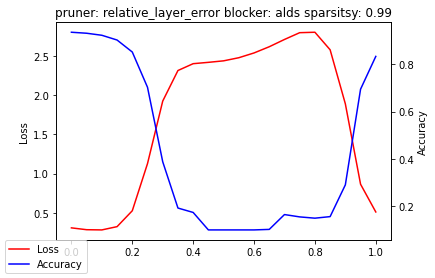

Pruned model num modules before collect: 62
[Test] Loss: 2.30258 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30258 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30226 | Accuracy: 0.0989
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


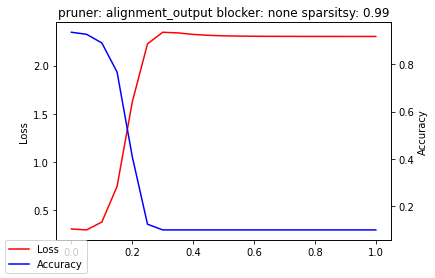

Pruned model num modules before collect: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Pruned model num modules: 62
[Test] Loss: 2.30259 | Accuracy: 0.1000
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30265 | Accuracy: 0.1000
Evaluated i=20 t=1.0 val_loss=2.303 val_acc*100=10.0%    c*100=10.0%    


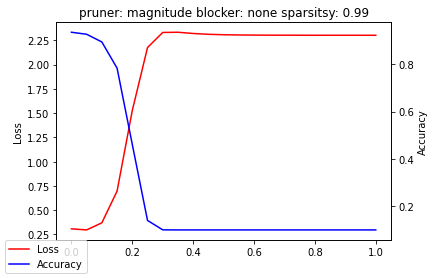

Pruned model num modules before collect: 62
[Test] Loss: 1.27760 | Accuracy: 0.5362
Pruned model num modules: 62
[Test] Loss: 1.27760 | Accuracy: 0.5362
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30290 | Accuracy: 0.1000
Evaluated i=20 t=1.0 val_loss=1.278 val_acc*100=53.6%    c*100=10.4%    


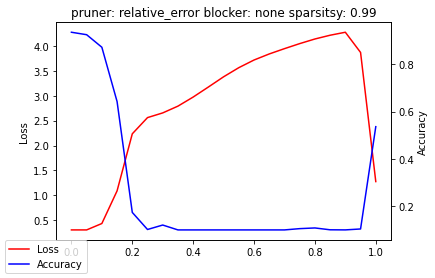

Pruned model num modules before collect: 62
[Test] Loss: 1.26208 | Accuracy: 0.5488
Pruned model num modules: 62
[Test] Loss: 1.26208 | Accuracy: 0.5488
Unpruned model num modules: 62
[Test] Loss: 0.30810 | Accuracy: 0.9352
Interpolation model num modules: 62
[Test] Loss: 2.30239 | Accuracy: 0.1000
Evaluated i=20 t=1.0 val_loss=1.262 val_acc*100=54.9%    c*100=10.4%    


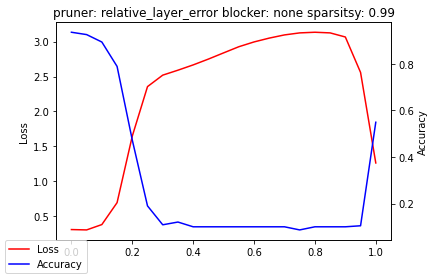

In [5]:
for sparsity in [0.95, 0.97, 0.99]:
    for blocker_name in ["square", "alds", "none"]:
        for pruner in ["alignment_output", "magnitude", "relative_error", "relative_layer_error"]:
            interpolate_plot(pruner, blocker_name, sparsity)